In [1]:
#!pip install astropy>=3.1
#!pip install sunpy
#!pip install imgaug==0.2.5
#!pip install stumpy
#!pip install scipy --upgrade
#restart runtime after installation, it should work then
import pandas as pd
#import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
import scipy
import sklearn
import copy

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH = '/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/'

Mounted at /content/drive


In [2]:
import time
start = 0*1440
n = start+1440
m=1

multiSeriesMain = pd.read_csv(DATASET_PATH+'482892868cd2ae0dd144842b47c7e94dbbe5d1efd8a4cb5d076a64750446cc79'+'.csv')
multiSeriesMain = multiSeriesMain.loc[:, ~multiSeriesMain.columns.str.contains('^Unnamed')].astype(float).reset_index(drop=True).T
multiSeries = multiSeriesMain.iloc[:,start:n]

multiSeries.describe()
print(multiSeries)

                                                     0      1      2     \
b9b4cd0a58698d599c38daf3a8db16450f4c93360167340...   43.0   45.0    0.0   
c2b6da45d6bc4ffdf300422e4f8cb8d80c1e07fadf32a1d...   41.0   15.0   12.0   
9dcdf0d081db5d849f5db8177422d990506864596f253a9...   22.0   16.0   12.0   
6c37a2d541025befc579c81f5e04c25376e25c14d2a0f2f...  152.0  175.0  144.0   
6fb111c7dd18a3003a3f25ff48b0fa9e9b0af51ad471a38...    0.0  704.0   61.0   
e1ba7f26822a9003c3afcee23f800915dff9877d1888c7a...  763.0  860.0  805.0   
c7d74c031ad41a8ac0cb0dd6fb1dd772f45b0cc13f9b876...   19.0    7.0    5.0   
4e0bf5950f95c9b5d1621a1b316f148b48e186eccd4c5a8...  291.0  300.0  309.0   
3dda431656096c485746d73a13009f7177a2f62ab29d846...   15.0    0.0    0.0   
a3b37937f21168e8f66b6622969f923412de4427a53df66...  119.0  132.0  105.0   
2cb14b99533f24a78aa3bbf7bbdc07c96f8ff8ddb5a4189...  164.0  282.0  240.0   
0b29bbce12777712de0e4062c382a40a35c9d58fe429c30...    1.0    2.0    1.0   
af0066d7dfb1fcbaafe48c683

In [6]:
def custom_bin_counter(x,y,k=12):
    q75, q25 = np.percentile(x, [75 ,25], axis=0)
    iqr = q75 - q25
    print(iqr)
    h = (2 * iqr) / ((x.shape[0])**(1/3))
    for i in range(len(h)):
        if h[i] == 0:
            h[i] = 1
    
    t = {}
    mins = x.min(axis=0)
    maxs = x.max(axis=0)
    
    ss = []
    total_bins = 1
    for i in range(len(h)):
        total_bins *= (maxs[i]-mins[i])/h[i]
        ss.append((maxs[i]-mins[i], h[i]))
    
    def get_bin_name(point):
        point = point - mins
        bin = [int(p/h[i]) for i,p in enumerate(point)]
        return bin
    
    binList = []

    for p in x:
      b = tuple(get_bin_name(p))
      binList.append(b)
      if b not in t:
          t[b] = 0
      t[b] += 1

    binIndexDict = {}
    for key in t:
      binIndexDict[key] = [i for i, x in enumerate(binList) if x==key]
    binWindowDict = {}
    for key in t:
      temp = []
      for index in binIndexDict[key]:
        temp.append(x[index])
      binWindowDict[key] = temp




    k_keys_sorted = sorted(t, key=t.get, reverse=True)[:k]
    
    x_counter = 0
    for k in k_keys_sorted:
        x_counter += t[k]
    
    y_counter = 0
    for j in y:
        b = tuple(get_bin_name(j))
        if b in k_keys_sorted:
            y_counter += 1
    return (x_counter/x.shape[0], y_counter/y.shape[0], x.shape[1],total_bins, binIndexDict, binWindowDict, k_keys_sorted,)
sumCoverage = 0
for i in range(0,14):
  multiSeriesOther = multiSeriesMain.iloc[:,i*1440:1440+(i*1440)]
  train_data = multiSeries.sort_index().values.transpose()
  test_data = multiSeriesOther.sort_index().values.transpose()
  train_coverage, test_coverage, dim, total_bins, binIndexDict, binWindowDict, keys = custom_bin_counter(train_data, test_data)
  sumCoverage += test_coverage
  print(train_coverage, test_coverage, dim, total_bins)
print('Sum of Coverage: ',sumCoverage/14)

[ 22.   130.     0.   194.   229.25  32.   137.25  41.   120.25   6.
 219.    55.25   9.   346.5 ]
0.015277777777777777 0.015277777777777777 14 3.1553582073982524e+22
[ 22.   130.     0.   194.   229.25  32.   137.25  41.   120.25   6.
 219.    55.25   9.   346.5 ]
0.015277777777777777 0.0020833333333333333 14 3.1553582073982524e+22
[ 22.   130.     0.   194.   229.25  32.   137.25  41.   120.25   6.
 219.    55.25   9.   346.5 ]
0.015277777777777777 0.001388888888888889 14 3.1553582073982524e+22
[ 22.   130.     0.   194.   229.25  32.   137.25  41.   120.25   6.
 219.    55.25   9.   346.5 ]
0.015277777777777777 0.0020833333333333333 14 3.1553582073982524e+22
[ 22.   130.     0.   194.   229.25  32.   137.25  41.   120.25   6.
 219.    55.25   9.   346.5 ]
0.015277777777777777 0.001388888888888889 14 3.1553582073982524e+22
[ 22.   130.     0.   194.   229.25  32.   137.25  41.   120.25   6.
 219.    55.25   9.   346.5 ]
0.015277777777777777 0.0020833333333333333 14 3.1553582073982524

In [4]:
for key in keys:
  print(key)
  for binIndex in binIndexDict[key]:
    print(binIndex)

(0, 0, 0, 3, 0, 8, 0, 0, 1, 0, 0, 0, 0, 0)
904
941
953
(0, 0, 0, 4, 0, 11, 0, 0, 2, 0, 0, 0, 0, 0)
906
927
942
(0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 5)
611
791
(0, 3, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 0, 9)
683
1247
(0, 0, 0, 3, 0, 14, 0, 0, 1, 0, 0, 0, 0, 2)
828
916
(0, 6, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 9)
899
1366
(0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0)
923
1077
(0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 1)
934
1379
(0, 7, 15, 8, 0, 26, 0, 3, 5, 3, 1, 4, 11, 12)
0
(0, 12, 0, 8, 0, 30, 28, 2, 6, 2, 1, 1, 4, 14)
1
(0, 10, 0, 8, 0, 25, 2, 1, 4, 0, 0, 1, 3, 13)
2
(0, 8, 0, 8, 1, 26, 1, 4, 7, 0, 3, 3, 2, 13)
3


NameError: ignored

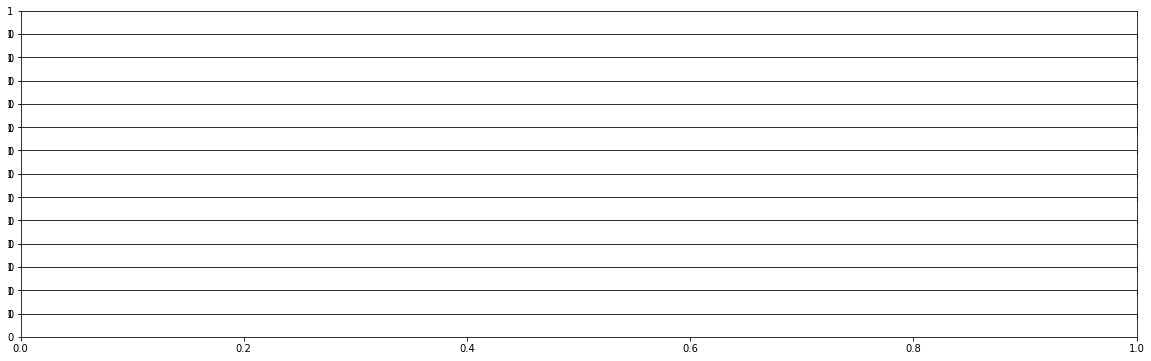

In [5]:
for key in keys:
  fig, axs = plt.subplots(len(multiSeries), sharex=True, gridspec_kw={'hspace': 0})
  axs[k].set_xlabel(key, fontsize ='20')
  for k, dim_name in enumerate(multiSeries.T.columns):
    axs[k].plot(multiSeries.T[dim_name])
    for binIndex in binIndexDict[key]:
      axs[k].axvline(binIndex, linestyle="dashed", c='black')

  plt.show()